In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Dependesi

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.callbacks import Callback
from mpl_toolkits.mplot3d import Axes3D
from keras.models import model_from_json, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

##Load Dataset

In [42]:
dataset_path = '/content/drive/MyDrive/train'

##Augmentasi data


In [48]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data generator untuk training dan validasi

In [49]:
train_generator = datagen.flow_from_directory(dataset_path,
                                              target_size=(64, 64),
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='training')
validation_generator = datagen.flow_from_directory(dataset_path,
                                                   target_size=(64, 64),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   subset='validation')

Found 2521 images belonging to 26 classes.
Found 0 images belonging to 26 classes.


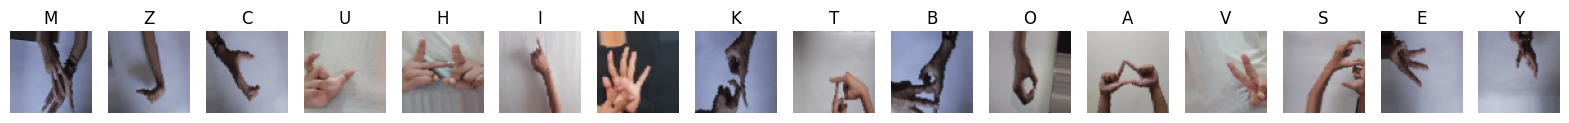

In [50]:
images, labels = next(train_generator)
labels = np.argmax(labels, axis=1)
class_labels = list(train_generator.class_indices.keys())

class_images = {}
for img, label in zip(images, labels):
    class_name = class_labels[label]
    if class_name not in class_images:
        img = img * 255.0 if img.max() <= 1 else img
        class_images[class_name] = img.astype('uint8')
    if len(class_images) == len(class_labels):
        break

# Plot Gambar
fig, axes = plt.subplots(1, len(class_images), figsize=(20, 20))
if len(class_images) == 1:
    axes = [axes]

for ax, (class_name, img) in zip(axes, class_images.items()):
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.show()


#Definisikan arsitektur model

In [51]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 12544)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

#Latih Model

In [52]:
history = model.fit(train_generator,
          epochs=10,
          validation_data=validation_generator)


Epoch 1/10
79/79 [==============================] - 61s 750ms/step - loss: 3.2750 - accuracy: 0.0333
Epoch 2/10
79/79 [==============================] - 60s 756ms/step - loss: 3.2591 - accuracy: 0.0329
Epoch 3/10
79/79 [==============================] - 59s 745ms/step - loss: 3.2541 - accuracy: 0.0528
Epoch 4/10
79/79 [==============================] - 60s 752ms/step - loss: 3.2280 - accuracy: 0.0643
Epoch 5/10
79/79 [==============================] - 60s 756ms/step - loss: 3.1504 - accuracy: 0.0916
Epoch 6/10
79/79 [==============================] - 60s 765ms/step - loss: 3.0339 - accuracy: 0.1305
Epoch 7/10
79/79 [==============================] - 59s 741ms/step - loss: 2.9112 - accuracy: 0.1495
Epoch 8/10
79/79 [==============================] - 58s 737ms/step - loss: 2.7855 - accuracy: 0.1761
Epoch 9/10
79/79 [==============================] - 57s 721ms/step - loss: 2.6810 - accuracy: 0.2007
Epoch 10/10
79/79 [==============================] - 58s 730ms/step - loss: 2.5308 - accura

#Save Model format Json & h5

In [8]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model_weights.h5")


In [9]:
with open("model.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model_weights.h5")

loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
from keras.models import model_from_json
with open("model.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model_weights.h5")

loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_array /= 255.0

    return img_array


In [ ]:

label_map = {i: chr(65 + i) for i in range(26)}

def predict_image(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = loaded_model.predict(img_array)
    predicted_label_index = np.argmax(predictions, axis=1)[0]
    predicted_abjad = label_map[predicted_label_index]

    return predicted_abjad
img_path = '/content/drive/MyDrive/dataset_capstone/train/B/B_unique_1264.JPG'
predicted_abjad = predict_image(img_path)
print(f"Predicted Abjad: {predicted_abjad}")


1/1 [==============================] - 0s 17ms/step
Predicted Abjad: B


In [ ]:
# from keras.models import model_from_json
# import numpy as np
# from keras.preprocessing import image

# with open("model.json", "r") as json_file:
#     loaded_model_json = json_file.read()
# loaded_model = model_from_json(loaded_model_json)

# loaded_model.load_weights("model_weights.h5")

# loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# def load_and_preprocess_image(img_path):
#     img = image.load_img(img_path, target_size=(64, 64))
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array /= 255.0
#     return img_array

# def predict_letter(model, img_path):
#     img_array = load_and_preprocess_image(img_path)
#     prediction = model.predict(img_array)
#     predicted_class = np.argmax(prediction, axis=1)
#     letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
#     return letters[predicted_class[0]]

# img_path = '/content/drive/MyDrive/dataset_capstone/train/D/D_unique_1913.JPG'
# predicted_letter = predict_letter(loaded_model, img_path)
# print(f"The predicted letter is: {predicted_letter}")


1/1 [==============================] - 0s 66ms/step
The predicted letter is: D


1/1 [==============================] - 0s 296ms/step


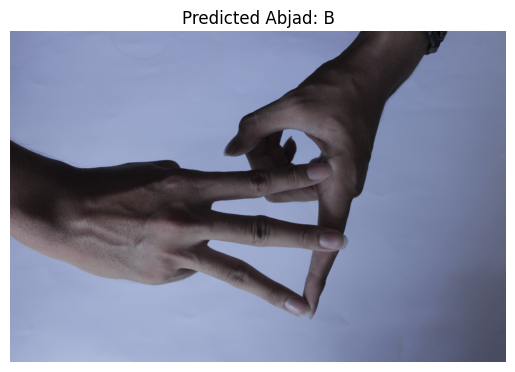

Predicted Abjad: B


In [ ]:
# from keras.models import model_from_json
# import numpy as np
# from keras.preprocessing import image
# import matplotlib.pyplot as plt


# with open("model.json", "r") as json_file:
#     loaded_model_json = json_file.read()
# loaded_model = model_from_json(loaded_model_json)


# loaded_model.load_weights("model_weights.h5")


# loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# def load_and_preprocess_image(img_path):
#     img = image.load_img(img_path, target_size=(64, 64))
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array /= 255.0
#     return img_array

# label_map = {i: chr(65 + i) for i in range(26)}

# def predict_image(img_path):
#     img_array = load_and_preprocess_image(img_path)

#     predictions = loaded_model.predict(img_array)
#     predicted_label_index = np.argmax(predictions, axis=1)[0]

#     predicted_abjad = label_map[predicted_label_index]

#     plt.imshow(image.load_img(img_path))
#     plt.title(f"Predicted Abjad: {predicted_abjad}")
#     plt.axis('off')
#     plt.show()

#     return predicted_abjad

# img_path = '/content/drive/MyDrive/dataset_capstone/train/B/B_unique_1264.JPG'  # Ganti dengan path gambar yang ingin diuji
# predicted_abjad = predict_image(img_path)
# print(f"Predicted Abjad: {predicted_abjad}")


FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 0s 62ms/step


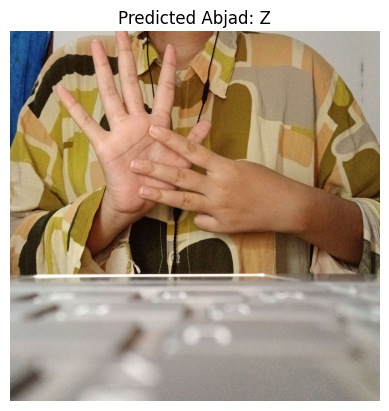

Predicted Abjad: Z
1/1 [==============================] - 0s 18ms/step


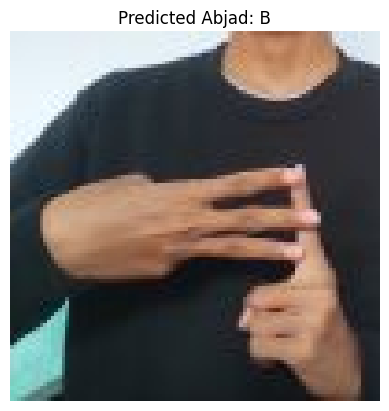

Predicted Abjad: B


In [13]:


with open("model.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model_weights.h5")

loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

def load_and_preprocess_image(img):
    img = image.load_img(img, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

label_map = {i: chr(65 + i) for i in range(26)}

def predict_image(img):
    img_array = load_and_preprocess_image(img)

    predictions = loaded_model.predict(img_array)
    predicted_label_index = np.argmax(predictions, axis=1)[0]

    predicted_abjad = label_map[predicted_label_index]

    plt.imshow(image.load_img(img))
    plt.title(f"Predicted Abjad: {predicted_abjad}")
    plt.axis('off')
    plt.show()

    return predicted_abjad

def on_upload_change(change):
    uploaded_file = list(change['new'].values())[0]
    img_path = uploaded_file['metadata']['name']
    with open(img_path, 'wb') as f:
        f.write(uploaded_file['content'])

    predicted_abjad = predict_image(img_path)
    print(f"Predicted Abjad: {predicted_abjad}")
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
upload_widget.observe(on_upload_change, names='value')
display(upload_widget)
